In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from loguru import logger
from tqdm import tqdm
import joblib
from src.config import INTERIM_DATA_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR

df_player_stats = pd.read_parquet(INTERIM_DATA_DIR / 'pstats.parquet')
df_player_stats = df_player_stats.drop(columns = ['fg_made_list', 'fg_missed_list', 'fg_blocked_list'])

2024-12-09 09:40:00.784 | INFO     | src.config:<module>:14 - PROJ_ROOT path is: G:\Work\DS\dont-bet-on-sports


In [2]:
stats_columns = [col for col in df_player_stats.select_dtypes(include=['float64', 'int64', 'int32', 'float32']).columns if col not in ['player_id', 'player_name', 'player_display_name', 'position',
 'position_group', 'headshot_url', 'season', 'week', 'season_type', 'team',
 'opponent_team']]

In [25]:
# Function to compute exponential moving average for a player's stats
def compute_exponential_average(player_df, span=7):
    """
    Computes exponential moving average for the player's stats up to (but not including) the current game.
    :param player_df: DataFrame containing data for a single player sorted by date or game order.
    :param span: Number of games to consider for the exponential moving average.
    :return: DataFrame with updated stats.
    """
    ema_df = player_df.copy()
    
    for col in stats_columns:
        ema_df[col] = player_df[col].shift(1).ewm(span=span, adjust=False).mean()  # Exclude current game using shift
    
    return ema_df

# Apply the function to each player group
span = 7  # User-defined span for EMA
df_pstats = pd.DataFrame()
for season in tqdm(range(2001, 2024)):
    df_pstats = pd.concat([df_pstats, df_player_stats.loc[df_player_stats['season'] == season].groupby('player_id', group_keys=False).apply(lambda group: compute_exponential_average(group, span)).fillna(0.)])


100%|██████████| 23/23 [26:39<00:00, 69.55s/it]


In [28]:
df_pstats.to_csv(INTERIM_DATA_DIR / 'ewm_pstats.csv')

In [3]:
df_pstats = pd.read_csv(INTERIM_DATA_DIR / 'ewm_pstats.csv')
df_pstats = df_pstats.iloc[:, 1:]

In [4]:
df_pstats.shape

(403807, 111)

In [6]:
processed_train_path: Path = INTERIM_DATA_DIR / "trainset.csv"
#processed_test_path: Path = PROCESSED_DATA_DIR / "testset.csv"

df_base = pd.read_csv(str(processed_train_path))
#df_test = pd.read_csv(str(processed_test_path), index_col= 'id')


def calc_r_spread(r: pd.Series):
    r['r_spread'] = (r.loc['tm_score'] - r.loc['opp_score']) / 100 #arbitrary normalization since no team would have a 100 point lead
    return r
df_base = df_base.apply(calc_r_spread, axis=1)
df_base = df_base.drop(columns=['tm_score', 'opp_score'])

### Create Dataset
Joining based on season, week, tm_alias and opp_alias

In [48]:
features = []
labels = []
ids = []

def calc_stats(r: pd.Series):
    tm_ = df_pstats.loc[(df_pstats['season'] == r['season']) & (df_pstats['week'] == r['week']) & (df_pstats['team'] == r['tm_alias']) & (df_pstats['opponent_team'] == r['opp_alias']), stats_columns].sort_values(by='fantasy_points',ascending=False)[:10].apply(pd.to_numeric, errors='coerce').fillna(0.)
    opp_ = df_pstats.loc[(df_pstats['season'] == r['season']) & (df_pstats['week'] == r['week']) & (df_pstats['team'] == r['opp_alias']) & (df_pstats['opponent_team'] == r['tm_alias']), stats_columns].sort_values(by='fantasy_points',ascending=False)[:10].apply(pd.to_numeric, errors='coerce').fillna(0.)
    if tm_.empty or opp_.empty:
        return 
    label_ = r['r_spread']

    features.append([tm_.to_numpy(), opp_.to_numpy(),])
    labels.append([r['event_date'], r['tm_spread'], float(label_)])
    ids.append(r['id'])

for season in tqdm(range(2001, 2024)):
    df_base.loc[(df_base['season'] == season)].apply(calc_stats, axis=1)


100%|██████████| 23/23 [07:25<00:00, 19.35s/it]


In [49]:
tm_stats = pd.read_csv(PROCESSED_DATA_DIR / 'scaled/trainset.csv', index_col='id')
tm_stats = tm_stats.loc[ids].reset_index().drop(columns=['id', 'tm_spread', 'opp_spread'])

In [50]:
np.shape(features)

(4482, 2, 10, 100)

In [51]:
np.shape(labels)

(4482, 3)

In [52]:
tm_stats.shape

(4482, 169)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


# Step 2: Dataset Preparation
class NFLDataset(Dataset):
    def __init__(self, features, labels, extra_features):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.extra_features = torch.tensor(extra_features, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx][0], self.features[idx][1], self.extra_features[idx], self.labels[idx] #home team, away team, r_spread

class BettingModel(nn.Module):
    def __init__(self, input_shape, extra_dims):
        super(BettingModel, self).__init__()
        # Convolutional layer for player-level data
        self.conv = nn.Conv1d(in_channels=input_shape[3], out_channels=input_shape[3], kernel_size=input_shape[2])
        self.flatten = nn.Flatten()

        # Dense layers
        self.fc1 = nn.Linear(2 * input_shape[3] + extra_dims, 64)  # Updated based on flattened output size
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, home_team, away_team, extra_features):
        # Convolution and flatten for home and away teams
        home_features = self.conv(home_team).squeeze(2)
        away_features = self.conv(away_team).squeeze(2)
        # Combine team-level features
        combined_player_features = torch.cat((home_features, away_features), dim=1)
        combined = torch.cat((combined_player_features, extra_features), dim = 1)

        # Dense layers
        x = F.leaky_relu(self.fc1(combined))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        return x



def train_model(model, dataloader, optimizer, loss_fn, scheduler, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for home_team, away_team, extra_features, labels in dataloader:
            home_team = home_team.transpose(1, 2)
            away_team = away_team.transpose(1, 2)
            optimizer.zero_grad()
            predictions = model(home_team, away_team, extra_features).squeeze(1)

            loss = loss_fn(predictions, labels.squeeze())
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        # Adjust learning rate with scheduler
        scheduler.step(loss)

# Step 5: Betting Strategy
def betting_strategy(predictions, odds):
    # Example: Maximize expected profit
    expected_profit = predictions * odds - 1
    return torch.argmax(expected_profit)


In [57]:
from sklearn.model_selection import train_test_split

train_features, test_features = train_test_split(features, test_size=0.2, shuffle=False)
train_labels, test_labels = train_test_split(labels, test_size=0.2, shuffle=False)
train_extra, test_extra = train_test_split(tm_stats, test_size=0.2, shuffle=False)

train_dataset = NFLDataset(np.array(train_features), np.array(train_labels)[:,2:].astype(float).squeeze(), train_extra.to_numpy())
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = NFLDataset(np.array(test_features), np.array(test_labels)[:,2:].astype(float).squeeze(), test_extra.to_numpy())
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [58]:
# Model, Optimizer, Loss
input_shape = np.shape(features) 
model = BettingModel(input_shape=input_shape, extra_dims=tm_stats.shape[1])
# Define loss function and optimizer
criterion = nn.L1Loss()  # Using MAE
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Train model
train_model(model, train_dataloader, optimizer, criterion, scheduler, 200)

Epoch [10/200], Loss: 0.0092
Epoch [20/200], Loss: 0.0001
Epoch [30/200], Loss: 0.0003
Epoch [40/200], Loss: 0.0002
Epoch [50/200], Loss: 0.0002
Epoch [60/200], Loss: 0.0001
Epoch [70/200], Loss: 0.0001
Epoch [80/200], Loss: 0.0001
Epoch [90/200], Loss: 0.0002
Epoch [100/200], Loss: 0.0001
Epoch [110/200], Loss: 0.0000
Epoch [120/200], Loss: 0.0000
Epoch [130/200], Loss: 0.0000
Epoch [140/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [160/200], Loss: 0.0000
Epoch [170/200], Loss: 0.0000
Epoch [180/200], Loss: 0.0000
Epoch [190/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000


In [59]:
from src.config import MODELS_DIR

nn_path = MODELS_DIR / "cnn.pt"
torch.save(model.state_dict(), str(nn_path))
logger.info("Neural Network trained")

2024-12-09 10:44:44.460 | INFO     | __main__:<module>:5 - Neural Network trained


In [60]:
# Predict and strategize
model.eval()
with torch.no_grad():
    predictions = []
    for home_team, away_team, extra_features, _ in test_dataloader:
        home_team = home_team.permute(0, 2, 1)
        away_team = away_team.permute(0, 2, 1)
        pred = model(home_team, away_team, extra_features).squeeze(1)
        predictions.append(pred)
    predictions = torch.cat(predictions)



In [61]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(np.array(test_labels)[:,2:].squeeze(1).astype(float) * 100, predictions * 100)

0.21789105445844273

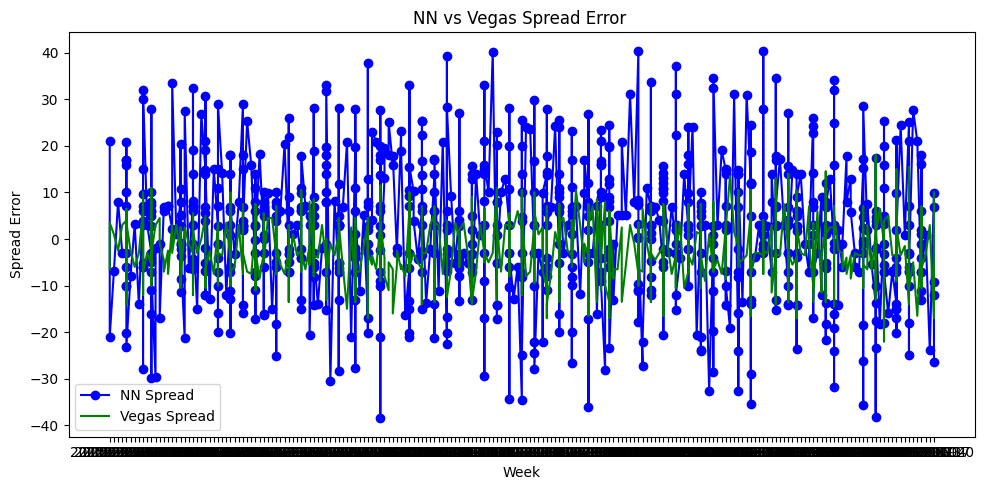

In [62]:
plot_preds(test_labels, predictions.tolist())

2024-12-09 11:18:18.140 | INFO     | __main__:plot_sim:45 - Total Games: 897
2024-12-09 11:18:18.141 | INFO     | __main__:plot_sim:46 - Total Bets: 516
2024-12-09 11:18:18.141 | INFO     | __main__:plot_sim:47 - Total Wagered: 56760
2024-12-09 11:18:18.143 | INFO     | __main__:plot_sim:48 - Total PnL: 18000
2024-12-09 11:18:18.144 | INFO     | __main__:plot_sim:49 - Bets Won: 356
2024-12-09 11:18:18.144 | INFO     | __main__:plot_sim:50 - Win Rate: 68.9922480620155
2024-12-09 11:18:18.145 | INFO     | __main__:plot_sim:51 - Return on Investment (ROI): 31.712473572938688


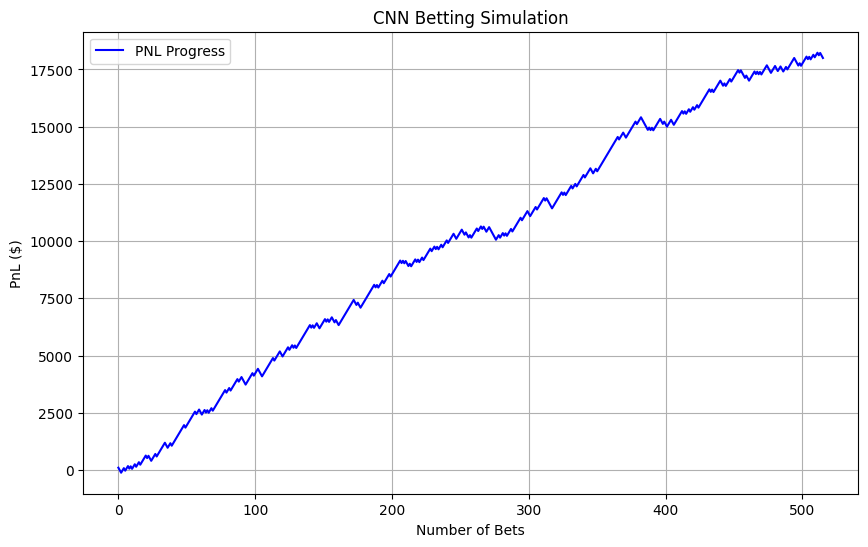

In [70]:
plot_sim(test_labels, predictions.tolist(), 'CNN', 0)

In [44]:
def plot_sim(labels, predictions, model: str, threshold: int):
    df_pred = pd.DataFrame({'r_spread': np.array(labels)[:,2:].squeeze(1).astype(float) * 100, 'pred': [prediction * 100 for prediction in predictions], 'spread_line': np.array(labels)[:,1:2].squeeze(1).astype(float)})
    # Initialize variables for pnl and profit/loss
    current_pnl = 0
    wager_amount = 110  # Wager $110 per bet to win $100
    total_wagered = 0
    bets_won = 0
    total_games = df_pred.shape[0]

    # Initialize a list to store pnl after each bet
    pnl_progress = []

    # Loop through each row to simulate the bets
    for index, row in df_pred.iterrows():
        actual_r_spread = row['r_spread']
        prediction = row['pred']
        spread_line = row['spread_line']
        
        # Betting strategy: Bet on the team if pred > spread_line (predicting the team will cover the spread)
        if spread_line < 0 and (prediction - abs(spread_line)) > threshold:
            # If actual r_spread (team's win margin) covers the spread line, bet wins
            total_wagered+=wager_amount
            if actual_r_spread > abs(spread_line):
                current_pnl += 100  # Win $100
                bets_won+=1
            else:
                current_pnl -= wager_amount  # Lose $110 due to vigorish (110)
        elif spread_line > 0 and (abs(prediction) - spread_line) > threshold:
            # If actual r_spread (team's win margin) covers the spread line, bet wins
            total_wagered+=wager_amount
            if actual_r_spread > -spread_line:
                current_pnl += 100  # Win $100
                bets_won+=1
            else:
                current_pnl -= wager_amount  # Lose $110 due to vigorish (110)


        # Append the current pnl to the list for tracking progress
        pnl_progress.append(current_pnl)

    # Add the pnl progress to the DataFrame for visualization
    df_pred['pnl'] = pnl_progress
    squeezed_pnl = df_pred['pnl'].loc[df_pred['pnl'].shift() != df_pred['pnl']].reset_index(drop=True)

    logger.info(f'Total Games: {total_games}')
    logger.info(f'Total Bets: {round(total_wagered/110)}')
    logger.info(f"Total Wagered: {total_wagered}")
    logger.info(f"Total PnL: {current_pnl}")
    logger.info(f'Bets Won: {bets_won}')
    logger.info(f'Win Rate: {(bets_won/(total_wagered/110))*100}')
    logger.info(f'Return on Investment (ROI): {(current_pnl/(total_wagered))*100}')
    # Plot the pnl progression over time (as bets progress)
    plt.figure(figsize=(10, 6))
    plt.plot(squeezed_pnl, label='PNL Progress', color='b')
    plt.title(f'{model} Betting Simulation')
    plt.xlabel('Number of Bets')
    plt.ylabel('PnL ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [43]:
def plot_preds(labels, predictions):
    df_pred = pd.DataFrame({'date': np.array(labels)[:,0:1].squeeze(1), 'pred': [prediction * 100 for prediction in predictions], 'spread_line': np.array(labels)[:,1:2].squeeze(1).astype(float)})
    plt.figure(figsize=(10,5))
    plt.plot(df_pred.loc[:,'date'], df_pred.loc[:,'pred'], marker='o', label='NN Spread', color='b')
    plt.plot(df_pred.loc[:,'date'], df_pred.loc[:,'spread_line'], label='Vegas Spread', color='g')


    plt.xlabel('Week')
    plt.ylabel('Spread Error')
    plt.title('NN vs Vegas Spread Error ')
    plt.legend()
    plt.tight_layout()
    plt.show()